In [37]:
#! pip install pandas numpy matplotlib seaborn jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.1 MB/s eta 0:00:00


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

In [26]:
def parse_semester(semester_str):
    try:
        # Ví dụ: "HK1 2020-2021" -> Lấy năm 2020 * 10 + 1 = 20201
        parts = semester_str.split(' ')
        hk = int(parts[0].replace('HK', ''))
        year = int(parts[1].split('-')[0])
        return year * 10 + hk
    except:
        return 0

In [27]:
def get_semester_start_year(semester_str):
    try:
        # Ví dụ: "HK1 2020-2021" -> Lấy năm 2020
        parts = semester_str.split(' ')
        year = int(parts[1].split('-')[0])
        return year
    except:
        return np.nan # Trả về NaN nếu xảy ra lỗi

In [28]:
def map_tohop_group(tohop_xt):
    if tohop_xt in ['A00', 'A01', 'A02', 'B00', 'D07']:
        return 'Tự nhiên + Kỹ Thuật'
    elif tohop_xt in ['C00', 'C01', 'C02', 'C03', 'C04']:
        return 'Xã hội'
    elif tohop_xt in ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D09', 'D10', 'D11', 'D14', 'D15']:
        return 'Tổng hợp + Ngoại ngữ'
    elif tohop_xt in ['H00', 'H01', 'V00', 'V01', 'N00']:
        return 'Nghệ thuật + Sáng tạo'
    else:
        return 'Đặc thù + khác'

1. Data Collection + ETL

In [29]:
print("Đang đọc dữ liệu")
# uploaded = files.upload()
try:
    admission = pd.read_csv('admission.csv')
    academic = pd.read_csv('academic_records.csv')
    print("Đã đọc dữ liệu thành công")
except:
    print("Lỗi: Tên file không đúng, đảm bảo upload file có tên chính xác là: admission.csv, academic_records.csv")

Đang đọc dữ liệu
Đã đọc dữ liệu thành công


In [30]:
# 1. Chuẩn hóa học kỳ để sắp xếp thời gian
academic['semester_rank'] = academic['HOC_KY'].apply(parse_semester)

# 2. Gộp data để tính lịch sử
df_combined = academic.copy()
# Sắp xếp theo sinh viên và thời gian
df_combined = df_combined.sort_values(by=['MA_SO_SV', 'semester_rank']).reset_index(drop=True)

# Tính số tín chỉ rớt của từng kỳ (Dùng cho quá khứ)
df_combined['credits_failed_current'] = df_combined['TC_DANGKY'] - df_combined['TC_HOANTHANH']
# Nếu tính ra số âm (do lỗi data) thì gán bằng 0
df_combined['credits_failed_current'] = df_combined['credits_failed_current'].apply(lambda x: max(0, x) if pd.notnull(x) else 0)

# Nhóm theo sinh viên để tính toán
grouped = df_combined.groupby('MA_SO_SV')

# a. GPA trung bình: Trung bình cộng dồn của các kỳ trước
# shift(1): Tại kỳ hiện tại, chỉ nhìn thấy dữ liệu kỳ trước đó trở về trước
df_combined['hist_avg_gpa'] = grouped['GPA'].transform(lambda x: x.shift(1).expanding().mean())

# b. CPA kỳ gần nhất
df_combined['last_cpa'] = grouped['CPA'].transform(lambda x: x.shift(1))

# c. Tổng số tín chỉ đã từng trượt
df_combined['hist_total_failed'] = grouped['credits_failed_current'].transform(lambda x: x.shift(1).expanding().sum())

# d. Xu hướng GPA (tăng/giảm so với kỳ trước nữa)
# Lấy GPA kỳ trước
df_combined['last_gpa'] = grouped['GPA'].transform(lambda x: x.shift(1))
# Lấy GPA kỳ trước nữa
df_combined['second_last_gpa'] = grouped['GPA'].transform(lambda x: x.shift(2))
# Xu hướng = Kỳ trước - Kỳ trước nữa
df_combined['gpa_trend'] = df_combined['last_gpa'] - df_combined['second_last_gpa']

# Điền 0 vào những giá trị trống (ví dụ sinh viên mới vào trường kỳ 1 thì chưa có lịch sử)
cols_fillna = ['hist_avg_gpa', 'last_cpa', 'hist_total_failed', 'gpa_trend', 'last_gpa']
df_combined[cols_fillna] = df_combined[cols_fillna].fillna(0)

# 3. Ghép thông tin tuyển sinh (Admission)
final_df = df_combined.merge(admission, on='MA_SO_SV', how='left')

#e. Nhóm tổ hợp xét tuyển
final_df['TOHOP_GROUP'] = final_df['TOHOP_XT'].apply(map_tohop_group)

#f. Năm học (1,2,3,4,5) của sinh viên
# Tạo cột 'semester_start_year' để lấy năm bắt đầu của học kỳ
final_df['semester_start_year'] = final_df['HOC_KY'].apply(get_semester_start_year)

# Tính toán cột 'NAM_HOC'
# NAM_HOC = Năm bắt đầu học kỳ - Năm tuyển sinh + 1
final_df['NAM_HOC'] = final_df['semester_start_year'] - final_df['NAM_TUYENSINH'] + 1

# Làm tròn và chuyển đổi sang kiểu số nguyên, điền 0 cho NaN nếu có
final_df['NAM_HOC'] = final_df['NAM_HOC'].fillna(0).astype(int)

In [31]:
# XUẤT FILE KẾT QUẢ
semester_rank_hk1_2023 = parse_semester('HK1 2023-2024')
semester_rank_hk2_2023 = parse_semester('HK2 2023-2024')
# Chia tập train và valid
train_processed = final_df[(final_df['semester_rank'] <= semester_rank_hk1_2023)].copy()

valid_processed = final_df[(final_df['semester_rank'] == semester_rank_hk2_2023)].copy()

In [32]:
# Chọn các cột cần thiết để đưa vào Model
features = [
    'MA_SO_SV', 'HOC_KY','NAM_HOC',
    'TC_DANGKY',          # Input: Đăng ký kỳ này
    'hist_avg_gpa',       # Input: Lịch sử học lực
    'last_cpa',           # Input: CPA gần nhất
    'hist_total_failed',  # Input: Lịch sử nợ môn
    'gpa_trend',          # Input: Xu hướng GPA
    'TOHOP_GROUP',        # Input: Nhóm tổ hợp xét tuyển
    'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'PTXT' # Input: Đầu vào
]

In [33]:
# Tập train và validation có thêm cột đáp án (TC_HOANTHANH)
train_output = train_processed[features + ['TC_HOANTHANH']]
valid_output = valid_processed[features + ['TC_HOANTHANH']]

In [34]:
# Lưu xuống file CSV
train_output.to_csv('train_data_processed.csv', index=False)
valid_output.to_csv('valid_data_processed.csv', index=False)

print("\nĐÃ XỬ LÝ XONG!")
print(f"Kích thước tập Train: {train_output.shape}")
print(f"Kích thước tập Validation: {valid_output.shape}")


ĐÃ XỬ LÝ XONG!
Kích thước tập Train: (90582, 13)
Kích thước tập Validation: (15144, 13)


In [35]:
# Tải về
files.download('train_data_processed.csv')
files.download('valid_data_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2. EDA

EDA bổ sung: Ngưỡng giới hạn của tín chỉ đăng ký

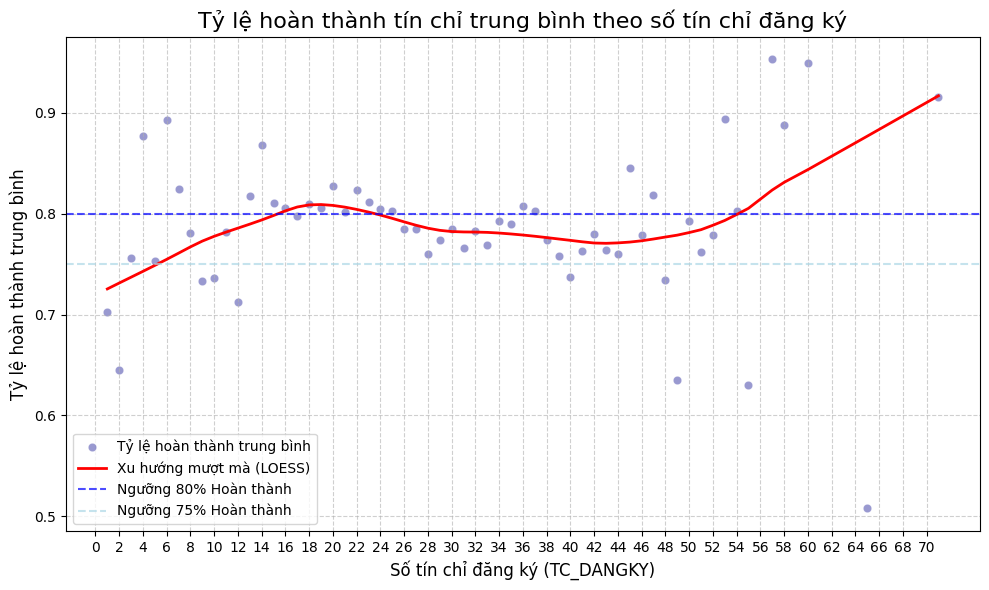

In [36]:
import statsmodels.api as sm

# Tạo một bản sao rõ ràng để tránh SettingWithCopyWarning
train_output_copy = train_output.copy()

# Tính biến 'completion_ratio'
# Xử lý trường hợp chia cho 0: nếu TC_DANGKY = 0 thì completion_ratio = 0 (vì TC_HOANTHANH cũng sẽ bằng 0)
train_output_copy['completion_ratio'] = train_output_copy.apply(
    lambda row: row['TC_HOANTHANH'] / row['TC_DANGKY'] if row['TC_DANGKY'] != 0 else 0,
    axis=1)

# Gom nhóm theo TC_DANGKY và tính completion_ratio trung bình
completion_by_registered_credits = train_output_copy.groupby('TC_DANGKY')['completion_ratio'].mean().reset_index()

# Tính đường xu hướng LOESS (Locally Estimated Scatterplot Smoothing)
# Chỉ tính cho các giá trị có đủ điểm dữ liệu (ví dụ: TC_DANGKY > 0)
lowess = sm.nonparametric.lowess(completion_by_registered_credits['completion_ratio'],
                                 completion_by_registered_credits['TC_DANGKY'],
                                 frac=0.3) # frac là phần trăm dữ liệu để tính mỗi điểm làm mịn
completion_by_registered_credits['completion_smooth'] = lowess[:, 1]

# Vẽ biểu đồ mối quan hệ
plt.figure(figsize=(10, 6))
sns.scatterplot(data=completion_by_registered_credits, x='TC_DANGKY', y='completion_ratio',
                label='Tỷ lệ hoàn thành trung bình', color='darkblue', alpha=0.4)
sns.lineplot(data=completion_by_registered_credits, x='TC_DANGKY', y='completion_smooth',
             label='Xu hướng mượt mà (LOESS)', color='red', linewidth=2)

plt.axhline(y=0.8, color='blue', linestyle='--', alpha=0.7, label='Ngưỡng 80% Hoàn thành')
plt.axhline(y=0.75, color='lightblue', linestyle='--', alpha=0.7, label='Ngưỡng 75% Hoàn thành')

plt.title('Tỷ lệ hoàn thành tín chỉ trung bình theo số tín chỉ đăng ký', fontsize=16)
plt.xlabel('Số tín chỉ đăng ký (TC_DANGKY)', fontsize=12)
plt.ylabel('Tỷ lệ hoàn thành trung bình', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(0, train_output_copy['TC_DANGKY'].max() + 1, 2)) # Điều chỉnh nhãn trục x để dễ quan sát
plt.legend(fontsize=10)
plt.tight_layout()
plt.show();

Dựa trên quan sát từ biểu đồ mối quan hệ giữa số tín chỉ đăng ký (TC_DANGKY) và tỷ lệ hoàn thành (completion_ratio), có thể nhận thấy sự suy giảm tương đối ổn định của completion_ratio khi số tín chỉ đăng ký tăng cao. Cụ thể, khi TC_DANGKY vượt khoảng 16–25 tín chỉ, tỷ lệ hoàn thành có xu hướng giảm xuống dưới 0.8–0.75, cho thấy sinh viên bắt đầu gặp khó khăn trong việc hoàn thành toàn bộ khối lượng học tập đã đăng ký.